# Cas9 Variants Off-Target Analysis

In [2]:
import pandas as pd
import gpplot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import roc_curve, auc

In [3]:
lfc_df = pd.read_table('../../data_v3/Fig 2_HF off-targets/processed/HF_off-target_CP1520_avglfc_v1.txt', index_col=0)
wt_cas9_cfd = pd.read_csv('../../data_v3/Fig 2_HF off-targets/external/cfd_2016.csv')
lib_meta = pd.read_csv('../../data_v3/Fig 2_HF off-targets/raw/cas9_variant_offtarget_lib_v3.csv')

## Merge lfcs with meta file 

In [4]:
lfc_df = pd.merge(lfc_df, lib_meta, left_on = 'Construct Barcode', right_on='Reference Mismatch Sequence', how='inner')

## Summarizing input data

There are 21 perfect match sequences and 1,000 controls.

In [4]:
lfc_df['ConstructID'].value_counts()

Essential       33041
Control           981
WT Essential       21
Name: ConstructID, dtype: int64

All guides are G19

In [5]:
lfc_df['G19'].value_counts()

y    33062
Name: G19, dtype: int64

About 1/4 of guides are g20

All PAMs are NGG except controls

In [6]:
lfc_df['PAM'].unique()

array(['TGGG', 'TGGT', 'AGGT', 'TGGA', 'GGGA', 'GGGT', 'AGGG', 'CGGT',
       'TGGC', 'AGGC', 'CGGG', 'NNNN'], dtype=object)

The majority of guides are double mismatches

In [7]:
lfc_df['Number of mismatches'].value_counts()

double     31854
single      1187
Control      981
none          21
Name: Number of mismatches, dtype: int64

There are some mismatched guides with 4 T's or a BsmBI site

In [8]:
lfc_df[['Duplicate', '4Ts', 'BsmBI site']].value_counts()

Duplicate  4Ts  BsmBI site
n          n    n             31681
           y    n               173
dtype: int64

We'll filter out guides that either have a 4T or BsmBI site

In [5]:
filtered_lfcs = lfc_df[(lfc_df['4Ts'] != 'y') &
                       (lfc_df['BsmBI site'] != 'y')]
print('Filtered ' + str(lfc_df.shape[0] - filtered_lfcs.shape[0]) + ' bad guides')

Filtered 173 bad guides


## Calculating the probability that each guide is active
We use the 21 perfect match guides as true positives and the 1000 control guides as true negatives to fit a logistic regression for each condition and predict whether each guide is a perfect match or control based on its log-fold change. We use the fit model to map from log-fold changes to the probability of being active (i.e. being a perfect match sgRNA). A value near 1 indicates a guide is active and a value near 0 indicates a guide is inactive.

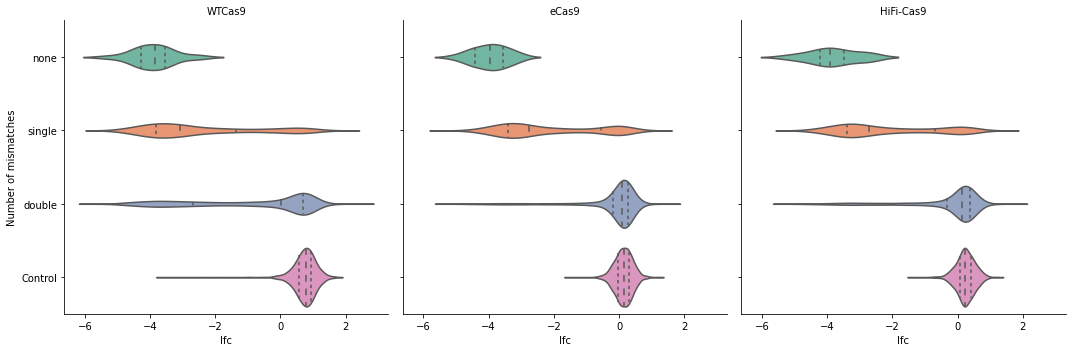

In [6]:
long_lfcs = (filtered_lfcs.melt(id_vars=['Construct Barcode', 'Construct IDs',
                                         'WT Sequence', 'Reference Mismatch Sequence',
                                         'PAM', 'g20', 'G20', 'Number of mismatches',
                                         'Type of Mismatch', 'Mismatch Position'],
                                value_vars=['A375_CP1520_RDA085_AVGLFC_frompDNA',
                                            'A375_CP1520_RDA152_AVGLFC_frompDNA',
                                            'A375_CP1520_RDA381_AVGLFC_frompDNA'],
                                var_name='condition', value_name='lfc')
             .rename({'Construct IDs': 'Target ID'}, axis=1))
long_lfcs['condition'] = long_lfcs['condition'].replace({'A375_CP1520_RDA085_AVGLFC_frompDNA': 'WTCas9',
                                                         'A375_CP1520_RDA152_AVGLFC_frompDNA': 'eCas9',
                                                         'A375_CP1520_RDA381_AVGLFC_frompDNA': 'HiFi-Cas9'})
long_lfcs['Number of mismatches'] = pd.Categorical(long_lfcs['Number of mismatches'], 
                                                   categories=['none', 'single', 'double', 'Control'])
g = sns.catplot(y='Number of mismatches', x='lfc',
                col="condition",
                data=long_lfcs,
                orient="h", palette="Set2",
                kind="violin", inner='quartile')
g.set_titles("{col_name}")

In [7]:
def build_logistic_model(data, activity_col, category_col, active_category):
    model = LogisticRegression(random_state=7)
    X = data[[activity_col]]
    y = data[category_col] == active_category
    model.fit(X, y)
    return model

def get_probability_active(data, activity_col, category_col, active_category, inactive_category):
    model_matrix = data[data[category_col].isin([active_category, inactive_category])]
    model = build_logistic_model(model_matrix, activity_col, category_col, active_category)
    data['active_probability'] = model.predict_proba(data[[activity_col]])[:,1] # 1 == active
    return data
    
active_probability_df = long_lfcs.groupby('condition').apply(lambda df: get_probability_active(df, 'lfc', 'Number of mismatches', 
                                                                       'none', 'Control'))

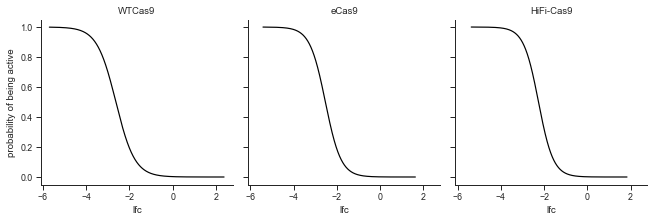

In [12]:
gpplot.set_aesthetics(context='paper')
g = sns.FacetGrid(active_probability_df.sort_values('lfc'), col='condition')
g.map_dataframe(sns.lineplot, x='lfc', y='active_probability', estimator=None, color='black')
g.set_titles("{col_name}")
g.set_axis_labels("lfc", "probability of being active")
plt.savefig('../../Figures/panels/Fig 2/probability of being active.pdf', bbox_inches = 'tight', transparent = True,
           dpi = 1000)


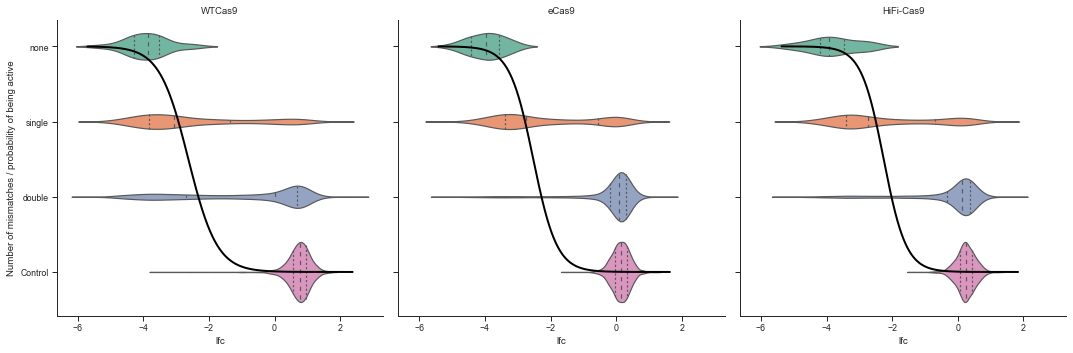

In [13]:
g = sns.catplot(y='Number of mismatches', x='lfc',
                col="condition",
                data=long_lfcs,
                orient="h", palette="Set2",
                kind="violin", inner='quartile')
g.set_titles("{col_name}")
g.set_axis_labels("lfc", "Number of mismatches / probability of being active")

axes = g.axes[0]
for ax in axes:
    condition = ax.title.get_text()
    condition_probability = active_probability_df[active_probability_df['condition'] == condition].sort_values('lfc')
    ax.plot(condition_probability['lfc'], (1-condition_probability['active_probability'])*3, color='black', lw=2)
    
plt.savefig('../../Figures/panels/Fig 2/probability of being active_v2.pdf', bbox_inches = 'tight', transparent = True,
           dpi = 1000) 

Ridge plots

In [14]:
long_lfcs['Number of mismatches'] = long_lfcs['Number of mismatches'].replace({'none' : 'Perfect Match',
                                                                              'single' : 'Single',
                                                                              'double': 'Double',
                                                                              'Control': 'Non-targeting Control'})

In [15]:
color_dictionary = dict({'Non-targeting Control':'#8da0cb',
                  'Double':'#fc8d62',
                  'Single': '#66c2a5',
                  'Perfect Match': '#e78ac3'})

In [16]:
wt_long = long_lfcs[long_lfcs['condition'] == 'WTCas9']

Text(0.5, 0.98, 'WTCas9')

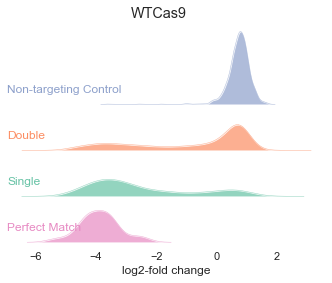

In [17]:
#WT
g = gpplot.ridgeplot(wt_long, 'lfc','Number of mismatches', palette=color_dictionary,
                     row_order = ['Non-targeting Control', 'Double', 'Single', 'Perfect Match'])
g.fig.subplots_adjust(hspace=-.4)
plt.xlabel('log2-fold change')
plt.suptitle('WTCas9')
#plt.savefig('../../Figures/panels/Fig 2/WT_ridge.pdf', bbox_inches ='tight', dpi = 1000, transparent='True')

In [18]:
ecas9_long = long_lfcs[long_lfcs['condition'] == 'eCas9']

Text(0.5, 0.98, 'eCas9')

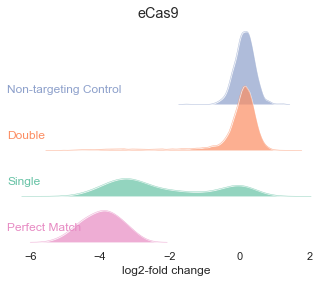

In [19]:
#eCas9
g = gpplot.ridgeplot(ecas9_long, 'lfc','Number of mismatches', palette=color_dictionary,
                     row_order = ['Non-targeting Control', 'Double', 'Single', 'Perfect Match'])
g.fig.subplots_adjust(hspace=-.4)
plt.xlabel('log2-fold change')
plt.suptitle('eCas9')
#plt.savefig('../../Figures/panels/Fig 2/eCas9_ridge.pdf', bbox_inches ='tight', dpi = 1000, transparent='True')

In [20]:
hifi_long = long_lfcs[long_lfcs['condition'] == 'HiFi-Cas9']

Text(0.5, 0.98, 'HiFi-Cas9')

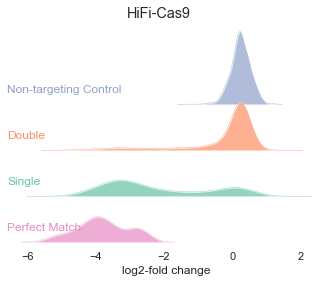

In [21]:
#HiFi
g = gpplot.ridgeplot(hifi_long, 'lfc','Number of mismatches', palette=color_dictionary,
                     row_order = ['Non-targeting Control', 'Double', 'Single', 'Perfect Match'])
g.fig.subplots_adjust(hspace=-.4)
plt.xlabel('log2-fold change')
plt.suptitle('HiFi-Cas9')
#plt.savefig('../../Figures/panels/Fig 2/HiFi_ridge.pdf', bbox_inches ='tight', dpi = 1000, transparent='True')

## Comparing across enzymes

We compare the averaged probabilities for each mismatch type and position between the Cas9 variants and see good correspondce. The high fidelity variants generally show less promiscuity at the PAM distal end of guides with eCas9 showing the least promiscuity

In [8]:
single_mismatch_active_probability = (active_probability_df[active_probability_df['Number of mismatches'] == 'single']
                                      .groupby(['Type of Mismatch', 'Mismatch Position', 'condition'])
                                      .agg(avg_active_prob_single = ('active_probability', 'mean'))
                                      .reset_index())
single_mismatch_active_probability['Mismatch Position'] = single_mismatch_active_probability['Mismatch Position'].astype(int)
spread_single_mismatch = (single_mismatch_active_probability.pivot_table(values='avg_active_prob_single', 
                                                                         index=['Type of Mismatch', 'Mismatch Position'], 
                                                                         columns=['condition'])
                          .reset_index())
spread_single_mismatch['Mismatch Position'] = spread_single_mismatch['Mismatch Position'].astype('int')

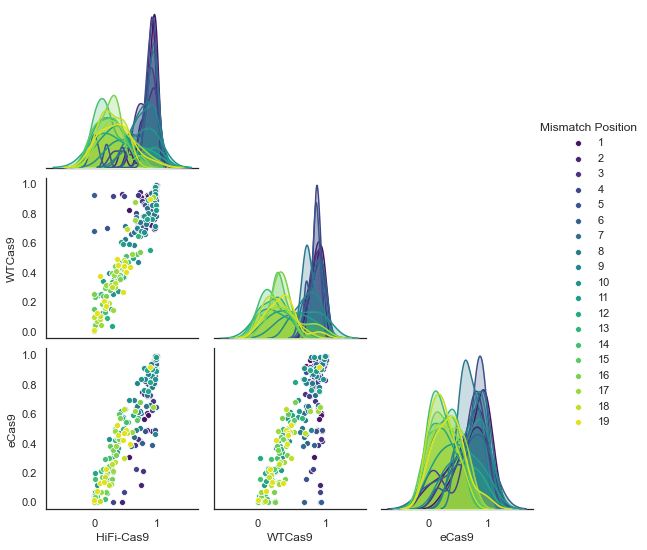

In [23]:
g = sns.pairplot(spread_single_mismatch, hue='Mismatch Position',  
                 corner=True, palette='viridis', aspect=1, diag_kind='kde', 
                 diag_kws={'clip': (0.0, 1.0)})

rG:dT mismatches are promiscuous across variant types

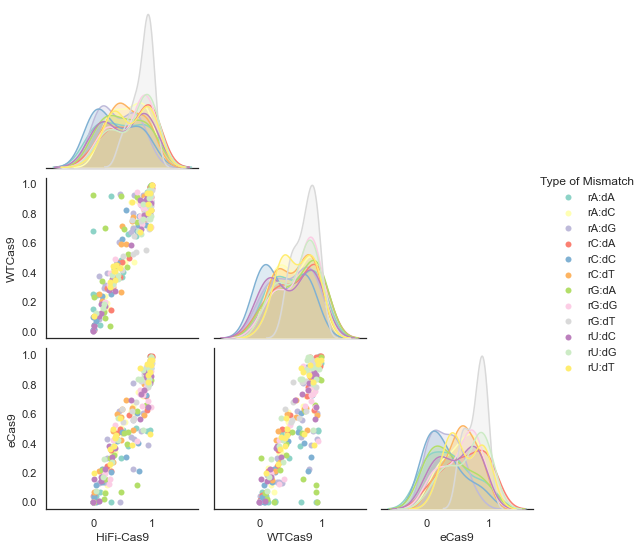

In [27]:
g = sns.pairplot(spread_single_mismatch.drop('Mismatch Position', axis=1), hue='Type of Mismatch',  
                 corner=True, palette='Set3', aspect=1, diag_kind='kde',
                 plot_kws=dict(linewidth=0),
                 diag_kws={'clip': (0.0, 1.0)})

plt.savefig('../../Figures/panels/Fig 2/HF mismatch type scatter_v2.pdf', transparent=True, dpi=1000)

When we compare against the activity values for wtCas9 in the 2016 RS2 paper we see a middling correlation of 0.61

In [ ]:
gpplot.set_aesthetics(context='paper', palette='Set2')
merged_cfds = spread_single_mismatch.merge(wt_cas9_cfd.rename({'Mismatch Type': 'Type of Mismatch',
                                                 'Position': 'Mismatch Position'}, axis=1), how='inner', 
                             on=['Type of Mismatch', 'Mismatch Position'])
fig, ax = plt.subplots(figsize=(3,3))
sns.scatterplot(data=merged_cfds, x='WTCas9', y='Percent-Active', ax=ax, linewidth=0)
gpplot.add_correlation(data=merged_cfds, x='WTCas9', y='Percent-Active')
plt.xlabel('CP1520 (2020)')
plt.ylabel('RS2 (2016)')
#plt.savefig('../../Figures/panels/Fig 2/WTCas9 CFD comparison_v2.pdf', transparent=True, dpi=1000, bbox_inches='tight')

## Predicting Double Mismatch Activity

To predict the double mismatches, we will multiply the average probability of each single mismatch together. Using the same logistic regression models as before we define any double mismatch guide with a > 50% probability of being a perfect match based on its log-fold change as active. Using this cutoff to define true positives and ranking by the multiplied single mismatch probabilities, we can see that we can predict the activity of the double mismatch guides fairly well. 

In [60]:
double_mismatch_df = active_probability_df[active_probability_df['Number of mismatches'] == 'double'].copy()
double_mismatch_df[['Type of Mismatch 1', 'Type of Mismatch 2']] = double_mismatch_df['Type of Mismatch'].str.split(',', expand=True)
double_mismatch_df[['Mismatch Position 1', 'Mismatch Position 2']] = double_mismatch_df['Mismatch Position'].str.split(',', expand=True)
double_mismatch_df[['Mismatch Position 1', 'Mismatch Position 2']] = double_mismatch_df[['Mismatch Position 1', 'Mismatch Position 2']].astype(int)

double_mismatch_df = double_mismatch_df.merge(single_mismatch_active_probability
                                              .rename({'Type of Mismatch': 'Type of Mismatch 1',
                                                       'Mismatch Position': 'Mismatch Position 1'}, axis=1), how='inner', 
                                              on = ['Type of Mismatch 1', 'Mismatch Position 1', 'condition'])
double_mismatch_df = double_mismatch_df.merge(single_mismatch_active_probability
                                              .rename({'Type of Mismatch': 'Type of Mismatch 2',
                                                       'Mismatch Position': 'Mismatch Position 2'}, axis=1), how='inner', 
                                              on = ['Type of Mismatch 2', 'Mismatch Position 2', 'condition'], 
                                              suffixes = [' 1', ' 2'])
double_mismatch_df['predicted_activity'] = double_mismatch_df['avg_active_prob_single 1'] * double_mismatch_df['avg_active_prob_single 2']
double_mismatch_df['active'] = double_mismatch_df['active_probability'] > 0.5

We see that wtCas9 has the most active double mismatch guides (n=8105), followed by IDT-Cas9 (n=3114) and then eCas9 (n=1592)

In [61]:
(double_mismatch_df.groupby('condition')['active'].value_counts())

condition  active
HiFi-Cas9  False     28566
           True       3115
WTCas9     False     23562
           True       8119
eCas9      False     30088
           True       1593
Name: active, dtype: int64

In [73]:
color_dict = {'HiFi-Cas9' : '#fb9a99',
             'eCas9' : '#b2df8a',
             'WTCas9': '#a6cee3'}

In [75]:
gpplot.set_aesthetics(context='paper')

Text(0.5, 0, 'False Positive Rate \n (Predicted + not observed active)')

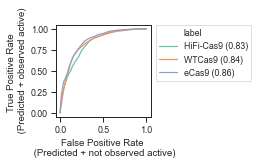

In [81]:
def get_roc_curves(df):
    fpr, tpr, _ = roc_curve(df['active'], df['predicted_activity'])
    roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
    return roc_df

roc_df = (double_mismatch_df
       .groupby('condition')
       .apply(lambda df: get_roc_curves(df))
       .reset_index(level=0))
auc_df = (roc_df
          .groupby('condition')
          .apply(lambda df: auc(df['fpr'], df['tpr']))
       .reset_index(name='auc'))
roc_auc_df = (roc_df.merge(auc_df, how='inner', on='condition'))
roc_auc_df['label'] = roc_auc_df.condition + ' (' + roc_auc_df.auc.round(decimals=2).astype(str) + ')'


fig, ax = plt.subplots(figsize=(1.7,1.7))
sns.lineplot(data=roc_auc_df, x='fpr', y='tpr', hue='label', estimator=None, ax=ax)
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.legend(facecolor='white', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('True Positive Rate \n (Predicted + observed active)')
plt.xlabel('False Positive Rate \n (Predicted + not observed active)')
#plt.title('Predicting active \n double mismatch sgRNAs')
#plt.savefig('../../Figures/panels/Fig 2/double_mismatch_roc_v3.pdf', dpi=1000, bbox_inches='tight', transparent=True)

## Outputs

In [59]:
output_df = (single_mismatch_active_probability.sort_values(['condition', 'Mismatch Position', 'Type of Mismatch'])
             .rename({'avg_active_prob_single': 'prob_active'}, axis=1))
output_df.to_csv('../../data_v3/Fig 2_HF off-targets/processed/cas9_hfvars_cfd_v2.csv', index=False)

## Heatmaps 

In [63]:
cfd = pd.read_csv('../../data_v3/Fig 2_HF off-targets/processed/cas9_hfvars_cfd_v2.csv')

In [64]:
cfd.head()

,Type of Mismatch,Mismatch Position,Mismatch Position_x,condition,prob_active
0,rA:dA,1,2,HiFi-Cas9,0.971616
1,rA:dC,1,2,HiFi-Cas9,0.939473
2,rA:dG,1,2,HiFi-Cas9,0.848982
3,rC:dA,1,2,HiFi-Cas9,0.990354
4,rC:dC,1,2,HiFi-Cas9,0.550277


Use Mismatch Position_x for plots -- this is because in reality, each of these guides screened has the 1st position fixed as a G

In [68]:
wt_cas9 = cfd[cfd['condition'] == 'WTCas9']
wt_cas9 = wt_cas9.pivot('Type of Mismatch', 'Mismatch Position_x', 'prob_active')

In [70]:
gpplot.set_aesthetics(context='notebook')

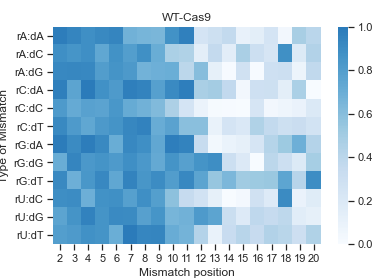

In [77]:
ax = sns.heatmap(wt_cas9, cmap = 'Blues', center = 0.7, vmin=0, vmax=1)
plt.xlabel('Mismatch position')
plt.title('WT-Cas9')
plt.savefig('../../Figures/panels/Fig 2/WT_CFD_v2.pdf', dpi=1000, bbox_inches='tight', transparent = True)

In [80]:
hifi = cfd[cfd['condition'] == 'HiFi-Cas9']
hifi = cfd[cfd['condition'] == 'HiFi-Cas9']
hifi = hifi.pivot('Type of Mismatch', 'Mismatch Position_x', 'prob_active')

In [81]:
gpplot.set_aesthetics(context='notebook')

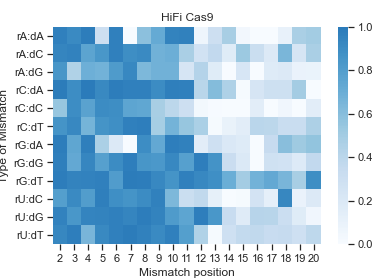

In [82]:
ax = sns.heatmap(hifi, cmap = 'Blues', center = 0.7, vmin=0, vmax=1)
plt.xlabel('Mismatch position')
plt.title('HiFi Cas9')
plt.savefig('../../Figures/panels/Fig 2/HiFi_CFD_v2.pdf', dpi=1000, bbox_inches='tight', transparent = True)

## Metric for comparing on and off-target activity

On-target activity: perfect match guides vs controls

Off-target: perfect match vs single or double

In [5]:
filtered_lfcs

,Construct Barcode,Construct IDs,A375_CP1520_RDA085_Rep A,A375_CP1520_RDA085_Rep B,A375_CP1520_RDA152_Rep A,A375_CP1520_RDA152_Rep B,A375_CP1520_RDA381_Rep A,A375_CP1520_RDA381_Rep B,A375_CP1520_RDA085_AVGLFC_frompDNA,A375_CP1520_RDA152_AVGLFC_frompDNA,...,Type of Mismatch,Mismatch Position,Length of WT Sequence,Duplicate,4Ts,BsmBI site,Gene stable ID,Gene stable ID version,Gene name,Chromosome/scaffold name
0,AGACCGGAGAATCCGCATCG,CIAO1,-3.631751,-3.126289,-3.452064,-2.837448,-2.314554,-2.274860,-3.379020,-3.144756,...,rA:dG,1,19.0,NaN,NaN,NaN,ENSG00000144021,ENSG00000144021.3,CIAO1,2.0
1,TGACCGGAGAATCCGCATCG,CIAO1,-2.356161,-3.555084,-3.875818,-4.012416,-2.494642,-3.341603,-2.955623,-3.944117,...,rU:dG,1,19.0,NaN,NaN,NaN,ENSG00000144021,ENSG00000144021.3,CIAO1,2.0
2,GGACCGGAGAATCCGCATCG,CIAO1,-4.127430,-3.660531,-3.674343,-3.153324,-3.846161,-2.698239,-3.893980,-3.413834,...,rG:dG,1,19.0,NaN,NaN,NaN,ENSG00000144021,ENSG00000144021.3,CIAO1,2.0
3,CAACCGGAGAATCCGCATCG,CIAO1,-3.720605,-3.326865,-3.965740,-3.020625,-3.170036,-4.065199,-3.523735,-3.493183,...,rA:dC,2,19.0,NaN,NaN,NaN,ENSG00000144021,ENSG00000144021.3,CIAO1,2.0
4,CTACCGGAGAATCCGCATCG,CIAO1,-3.830729,-3.124115,-3.406966,-3.745652,-3.769657,-2.944939,-3.477422,-3.576309,...,rU:dC,2,19.0,NaN,NaN,NaN,ENSG00000144021,ENSG00000144021.3,CIAO1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34038,GAACTGGTCCACGCCCACGG,EEF2,-4.535851,-4.218758,-3.950532,-4.368174,-4.146677,-3.673038,-4.377305,-4.159353,...,none,none,19.0,NaN,NaN,NaN,ENSG00000167658,ENSG00000167658.16,EEF2,NaN
34039,GACCAGGCTACCTTCCGCAG,CIAO1,-5.499883,-5.174379,-5.073992,-5.059447,-5.030971,-5.413177,-5.337131,-5.066719,...,none,none,19.0,NaN,NaN,NaN,ENSG00000144021,ENSG00000144021.3,CIAO1,NaN
34040,GACCCCGAGAACCAGGCGCG,RPP21,-3.298681,-3.904965,-3.615463,-4.379343,-3.274672,-4.539739,-3.601823,-3.997403,...,none,none,19.0,NaN,NaN,NaN,ENSG00000241370,ENSG00000241370.5,RPP21,NaN
34041,GGCACGGTCGAAGGTGCGGG,XAB2,-2.985175,-3.968066,-3.611467,-3.249414,-2.261580,-3.676558,-3.476620,-3.430440,...,none,none,19.0,NaN,NaN,NaN,ENSG00000076924,ENSG00000076924.12,XAB2,NaN


In [6]:
def get_roc_auc(df, col):
    df = df.sort_values(by=col)
    df['true-pos_cumsum'] = np.cumsum(df['ess-val'])
    #print(df['true-pos_cumsum'])
    df['false-pos_cumsum'] = np.cumsum(df['non-ess-val'])
    df['fpr'] = df['false-pos_cumsum']/(df['false-pos_cumsum'].iloc[-1])
    df['tpr'] = df['true-pos_cumsum']/(df['true-pos_cumsum'].iloc[-1])
    df.head()
    roc_auc = auc(df['fpr'],df['tpr'])
    roc_df = pd.DataFrame({'False_Positive_Rate':list(df.fpr), 'True_Positive_Rate':list(df.tpr)})
    return roc_auc, roc_df

In [7]:
single_control = filtered_lfcs[(filtered_lfcs['Number of mismatches'] == 'none')
                              |(filtered_lfcs['Number of mismatches'] == 'Control')]

In [8]:
single_control['ess-val'] = [1 if r['Number of mismatches'] == 'none' else 0 for i,r in single_control.iterrows()]
single_control['non-ess-val'] = [1 if r['Number of mismatches'] == 'Control' else 0 for i,r in single_control.iterrows()]

/Users/asangree/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/asangree/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
wt_auc, wt_roc = get_roc_auc(single_control, 'A375_CP1520_RDA085_AVGLFC_frompDNA')
wt_auc

0.9996116693364401

In [10]:
ecas_auc, ecas_roc = get_roc_auc(single_control, 'A375_CP1520_RDA152_AVGLFC_frompDNA')
ecas_auc

1.0

In [11]:
hifi_auc, hifi_roc = get_roc_auc(single_control, 'A375_CP1520_RDA381_AVGLFC_frompDNA')
hifi_auc

1.0

## Off-targets 

## Single mismatches 

In [12]:
perfect_single = filtered_lfcs[(filtered_lfcs['Number of mismatches'] == 'none')
                              |(filtered_lfcs['Number of mismatches'] == 'single')]

In [13]:
perfect_single['ess-val'] = [1 if r['Number of mismatches'] == 'none' else 0 for i,r in perfect_single.iterrows()]
perfect_single['non-ess-val'] = [1 if r['Number of mismatches'] == 'single' else 0 for i,r in perfect_single.iterrows()]

/Users/asangree/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/asangree/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
wt_single_auc, wt_single_roc = get_roc_auc(perfect_single, 'A375_CP1520_RDA085_AVGLFC_frompDNA')
wt_single_auc

0.7609820676375014

In [15]:
ecas_single_auc, ecas_single_roc = get_roc_auc(perfect_single, 'A375_CP1520_RDA152_AVGLFC_frompDNA')
ecas_single_auc

0.8829381794840936

In [16]:
hifi_single_auc, hifi_single_roc = get_roc_auc(perfect_single, 'A375_CP1520_RDA381_AVGLFC_frompDNA')
hifi_single_auc

0.8194327436113451

## Double mismatches 

In [17]:
perfect_double = filtered_lfcs[(filtered_lfcs['Number of mismatches'] == 'none')
                              |(filtered_lfcs['Number of mismatches'] == 'double')]

In [18]:
perfect_double['ess-val'] = [1 if r['Number of mismatches'] == 'none' else 0 for i,r in perfect_double.iterrows()]
perfect_double['non-ess-val'] = [1 if r['Number of mismatches'] == 'double' else 0 for i,r in perfect_double.iterrows()]

/Users/asangree/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/asangree/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
wt_double_auc, wt_double_roc = get_roc_auc(perfect_double, 'A375_CP1520_RDA085_AVGLFC_frompDNA')
wt_double_auc

0.8912402055610918

In [20]:
ecas_double_auc, ecas_double_roc = get_roc_auc(perfect_double, 'A375_CP1520_RDA152_AVGLFC_frompDNA')
ecas_double_auc

0.9845423349731927

In [21]:
hifi_double_auc, hifi_double_roc = get_roc_auc(perfect_double, 'A375_CP1520_RDA381_AVGLFC_frompDNA')
hifi_double_auc

0.9686367523872653

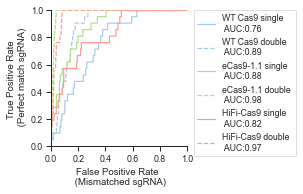

In [79]:
gpplot.set_aesthetics(context='paper')

fig, ax = plt.subplots(figsize=(2.5,2.5))

ax.plot(wt_single_roc.False_Positive_Rate, wt_single_roc.True_Positive_Rate, label='WT Cas9 single\n AUC:0.76', color = '#a6cee3')
ax.plot(wt_double_roc.False_Positive_Rate, wt_double_roc.True_Positive_Rate, label='WT Cas9 double \n AUC:0.89', color = '#a6cee3', linestyle='--')

ax.plot(ecas_single_roc.False_Positive_Rate, ecas_single_roc.True_Positive_Rate, label='eCas9-1.1 single \n AUC:0.88', color ='#b2df8a')
ax.plot(ecas_double_roc.False_Positive_Rate, ecas_double_roc.True_Positive_Rate, label='eCas9-1.1 double \n AUC:0.98', color = '#b2df8a', linestyle='--')

ax.plot(hifi_single_roc.False_Positive_Rate, hifi_single_roc.True_Positive_Rate, label='HiFi-Cas9 single \n AUC:0.82', color ='#fb9a99')
ax.plot(hifi_double_roc.False_Positive_Rate, hifi_double_roc.True_Positive_Rate, label='HiFi-Cas9 double \n AUC:0.97', color = '#fb9a99', linestyle='--')


ax.legend(facecolor='white', loc='lower left')
ax.set_aspect('equal')
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.xlabel('False Positive Rate \n (Mismatched sgRNA)')
plt.ylabel('True Positive Rate \n (Perfect match sgRNA)')
ax.legend(facecolor='white', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0, 1.0)
#plt.title ('SpG + Cas9-NG \n Off-target scores')
plt.xlim(0,1)
sns.despine()
plt.savefig('../../Figures/panels/Fig 2/ROC_AUC_HF_off-targets_v3.pdf', dpi=1000, bbox_inches='tight', transparent=True)
